# Exploring Employment and Projects of Insight Data Science Fellows
INSIGHT DATA SCIENCE FELLOWS PROGRAM is a very popular program for PhD/postdoc to transition into a career track of data scientist.
The objective for this analysis is to figure out:
* What are the employer statistics for the previous fellows?
* What type of projects did the fellow complete at Insight?

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

import mysql.connector

## Collect and Process Data
[Scott Cole](https://github.com/srcole/insightfellows/blob/master/Insight%20fellows%20summmary.ipynb) did a great analysis and fetched the data using BeautifulSoup. 

But the data only contains the information for 100 fellows on the first page. 
To get a more thorough view, I used another method, scrapy, to get the information for all the fellows listed on the website. 

### Use Scrapy to get the data from website

Code reference can be found in the folder 'InsightFellow_scrapy'

### Load and process data

In [2]:
work_dir = './'
df_fellows = pd.read_csv(work_dir+'/InsightFellow.csv')
columns = ['Name', 'Company', 'Title', 'Project', 'Background']
df_fellows = df_fellows[columns]
df_fellows.head()

,Name,Company,Title,Project,Background
0,JP Bida,Capital One,Director of Risk,Measuring the Impact of Open Source Coders on ...,"Bio-X Games, Stanford, Postdoc"
1,Douglas Mason,Twitter,Data Scientist,Email Searcher: Search & Visualize Your Mailbox,"Physics, Harvard University, PhD\n"
2,Virot Ta Chiraphadhanakul,Facebook,Data Scientist,Tweet Timeline: Visualizing the Impact of Soci...,"Operations Research, MIT, PhD"
3,Julia Viladomat,Adobe,Data Scientist,Sentiment Analysis Based on Social Media,"Statistics, Stanford, Postdoc"
4,David Freeman,LinkedIn,Head of Anti-Abuse Engineering,Flight Delay Predictor,"Mathematics, Stanford, Postdoc"


In [3]:
# parse background
df_background=df_fellows['Background'].apply(lambda x: x.replace('\n','')).apply(lambda x: x.split(',')).apply(pd.Series)[[0,1,2]]
df_background.columns = ['Major','Institution', 'Degree']
df_background.head()

,Major,Institution,Degree
0,Bio-X Games,Stanford,Postdoc
1,Physics,Harvard University,PhD
2,Operations Research,MIT,PhD
3,Statistics,Stanford,Postdoc
4,Mathematics,Stanford,Postdoc


In [4]:
#merge the two tables
df_insightfellow = pd.concat([df_fellows.drop('Background',axis=1),df_background], axis=1)
df_insightfellow.head()

,Name,Company,Title,Project,Major,Institution,Degree
0,JP Bida,Capital One,Director of Risk,Measuring the Impact of Open Source Coders on ...,Bio-X Games,Stanford,Postdoc
1,Douglas Mason,Twitter,Data Scientist,Email Searcher: Search & Visualize Your Mailbox,Physics,Harvard University,PhD
2,Virot Ta Chiraphadhanakul,Facebook,Data Scientist,Tweet Timeline: Visualizing the Impact of Soci...,Operations Research,MIT,PhD
3,Julia Viladomat,Adobe,Data Scientist,Sentiment Analysis Based on Social Media,Statistics,Stanford,Postdoc
4,David Freeman,LinkedIn,Head of Anti-Abuse Engineering,Flight Delay Predictor,Mathematics,Stanford,Postdoc


In [5]:
#create a new folder to save processed data files
rst_dir = os.path.join(work_dir,'Output_files')
if not os.path.exists(rst_dir):
    os.makedirs(rst_dir)

df_insightfellow.to_csv(os.path.join(rst_dir,'Insight_fellow_processed.csv'))
print(len(df_insightfellow))

794


## Analysis on Employers

### How many companies are hiring the fellows? What is the distribution for number of fellows hired in each company?

In [6]:
df_employer = pd.DataFrame(df_insightfellow.Company.value_counts()).reset_index()
df_employer.columns = ['Company', 'Number of Fellows Hired']
#df_employer.sort_values('Number of Fellows Hired',ascending = False)
df_employer['Percentage (%)'] = round(df_employer['Number of Fellows Hired']/df_employer['Number of Fellows Hired'].sum()*100, 2)
df_employer.head(10)

,Company,Number of Fellows Hired,Percentage (%)
0,Facebook,54,6.81
1,LinkedIn,21,2.65
2,Stitch Fix,19,2.40
3,Netflix,15,1.89
4,Intuit,14,1.77
5,Insight Data Science,13,1.64
6,Uber,12,1.51
7,Gartner,12,1.51
8,Yelp,12,1.51
9,Square,10,1.26


In [7]:
print(len(df_employer))

411


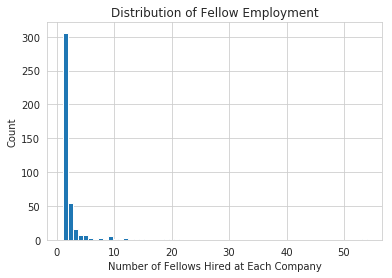

In [8]:
plt.figure(figsize=(10,6))
p1 = df_employer.hist(column='Number of Fellows Hired', bins=60)
plt.ylabel('Count')
plt.xlabel('Number of Fellows Hired at Each Company')
plt.title('Distribution of Fellow Employment')
#plt.ylim(0,10)
plt.savefig(os.path.join(rst_dir,'Employment_distribution.png'))

In [9]:
df_employer.groupby('Number of Fellows Hired').count().drop(columns='Percentage (%)').head()

,Company
Number of Fellows Hired,
1,306
2,54
3,16
4,7
5,7


In [10]:
# plot with plotly for an interactive graph
df_employer['Number of Fellows Hired'].iplot(kind='hist',
                                             xTitle='Number of Fellows Hired at Each Company', 
                                             yTitle='Count', title='Distribution of Fellow Employment')

### What are the top 30 employers that hired the most of fellows?

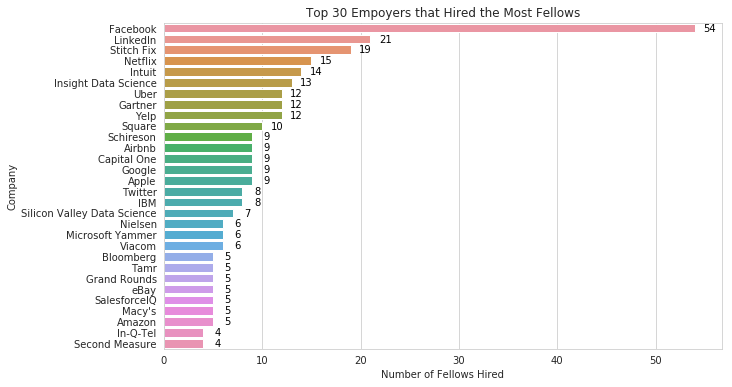

In [11]:
plt.figure(figsize=(10,6))
p2 = sns.barplot(x= 'Number of Fellows Hired' , y= 'Company', data=df_employer.head(30))
for p in p2.patches:
    width = p.get_width()
    p2.text(width + 1.5  ,
            p.get_y()+p.get_height()/2 +0.28, '{:0.0f}'.format(width), color = 'black', ha= 'center')
plt.title('Top 30 Empoyers that Hired the Most Fellows')
plt.savefig(os.path.join(rst_dir,'Employer_Barplot.png'))

## Analysis on Projects

### What are the words used most in the project titles?

In [12]:
CV = CountVectorizer()
X = CV.fit_transform(df_insightfellow['Project'])

df_wordcount = pd.DataFrame(columns=['Word','Count_All'])
df_wordcount['Word'] = CV.get_feature_names()
df_wordcount['Count_All'] = np.sum(X.toarray(),axis=0).T
df_wordcount = df_wordcount.sort_values('Count_All',ascending = False)
df_wordcount.head(20)

,Word,Count_All
2142,the,184
825,for,125
2410,your,120
2175,to,114
1048,in,88
785,find,78
1443,of,75
85,and,74
1451,on,69
1630,predicting,56


### What are the most 'special' words - highest TF-IDF?

In [13]:
df_tfidf = pd.DataFrame(columns=['Word','TF-IDF'])
V = TfidfVectorizer()
X = V.fit_transform(df_insightfellow['Project'])
df_tfidf['Word'] = V.get_feature_names()
df_tfidf['TF-IDF'] = np.max(X.toarray(), axis=0)
df_tfidf = df_tfidf.sort_values('TF-IDF', ascending=False)
df_tfidf.head(20)
#X.toarray().shape

,Word,TF-IDF
649,educare,1.0
2237,trustmepost,1.0
988,highlightr,1.0
2187,topichat,1.0
1003,homewords,1.0
1567,pigiback,1.0
1759,redcarpet,1.0
364,cleanstreet,1.0
362,cleanmachine,1.0
1752,recommendr,1.0


### Use wordcloud to visualize the more important key words

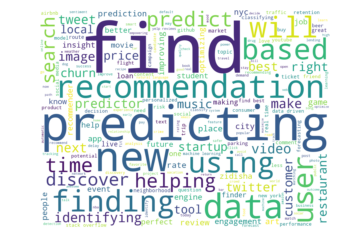

In [14]:
#str1 = ''.join(list1)
all_projects = ' '.join(df_fellows['Project']).lower()
wc = WordCloud(background_color="white", width=1600, height=1200).generate(all_projects)
wc.to_file(os.path.join(rst_dir,'AllProject_wordcloud.png'))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)

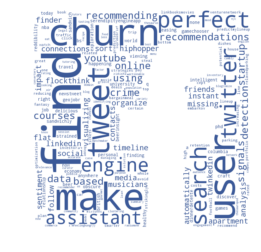

In [15]:
fb_projects = ' '.join(df_fellows[df_fellows['Company']=='Facebook']['Project']).lower()
fb_mask = np.array(Image.open(os.path.join(work_dir,"resources/facebook.png")))

wc = WordCloud(background_color="white", mask=fb_mask).generate(fb_projects)

# get color for text from image
fb_color = np.array(Image.open(os.path.join(work_dir,"resources/facebook_color.png")))
 
# apply the color to the text
image_colors = ImageColorGenerator(fb_color)
wc.recolor(color_func=image_colors)


wc.to_file(os.path.join(rst_dir,'FacebookProject_wordcloud.png'))

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)


In [16]:
pd.set_option('display.max_colwidth', -1)

FB = df_fellows[df_fellows['Company']=='Facebook']
FB_project = FB[['Project']]
FB_project.head(10)

,Project
2,Tweet Timeline: Visualizing the Impact of Social Media
10,Sort My Friends: Automatically Organize your Connections
11,Flat Finder: Find Your Perfect Apartment
21,HipHopper: Find The Musicians You Have Been Missing
23,FlockThink: Twitter Search Engine For Instant Sentiment Analysis
28,TwinkedIn: Follow LinkedIn Contacts on Twitter
31,SerendipityEngineApp: Your Personal Travel Assistant
38,Sandwichly: Make The Perfect Sandwich
40,GeoJobr: Finding a job in today's economy
42,"GameChooser: Intelligent viewing recommendations for NBA games, The University of British Columbia, PhD"


## List the projects that contain the key word 'churn'

In [17]:
# use SQL query and export into csv file
churn = pd.read_csv(os.path.join(rst_dir,'Project_churn.csv'))
churn

,Company,Project
0,Facebook,Churn Prediction at Strikingly: Reducing costs of retention strategies
1,Premise,Churn Modeling: PRedicting customer churn for Salesforce usage data
2,Facebook,Churn Signals: Identifying actionable signals on churn for an e-commerce company
3,Remind,Unleash Your Inner Rockstar: User retention and churn at a mobile app startup
4,Playtika,Predicting worker churn: Will they stay or will they go?
5,Vanguard,ClientKeeper: Engagement and churn in B2B relationships
6,Netflix,Churn at Gobble
7,Microsoft,Please don't go!: Predicting customer churn
8,Wayfair,Churn-No-More: Discovering what drives customer churn vs. retention


## Overall insights summary
* Information of ~ 800 fellow  was listed on the website
* Facebook hired the biggest number of fellows ~6.8%, followed by Linkedin and Stitch Fix
* Over 300 companies hired only one fellow
* Key words used in the projects include: find/predict/recommendation/user/twitter,etc.